# 2D FIR II JTAG Demo

## Target Setup

Change Below to match your target setup

In [1]:
#Setup Specific Target Bus, Width, Height
bus_target = 0  # 0 for Max10 & Arria 10,  1 for Agilex 7 (to avoid Max10 System controller)
width = 320     # 320 for Max10, 400 for Arria 10 & Agilex 7
height = 200    # 200 for Max10, 320 for Arria 10 & Agilex 7

size = width * height

read_buffer = 0x10          # Leave room for config packet
write_buffer = size+0x4     # Start write buffer after read buffer full length

## Connect to JTAG

Program FPGA through JTAG via programmer GUI or TCL shell:

`quartus_pgm -c 1 -m JTAG -o "p;dma_ex.sof"`

Run this command locally with Quartus TCL shell:

`./syscon/bin/system-console.exe --cli --rc_script=../tcl/tcl_server/tcl_server.tcl`

Connect to Telnet

In [2]:
from tcl_client import *
cl = Tcl_client()
cl.open()

Connect to Agilex JTAG MM

In [3]:
command = "open_bus {0}".format(bus_target)
cl.send_command(command)

'/devices/10M50DA(.|ES)|10M50DC@1#USB-1#Arrow MAX 10 DECA/(link)/JTAG/(110:132 v1 #0)/phy_0/master EOF'

FPGA read/write Utility

In [4]:
def fpga_read(addr):
    command = "read_32 {0} 1".format(addr)
    retval = cl.send_command(command)
    return int(retval[2:10],16)

def fpga_write(addr,value):
    command = "write_32 {0} {1}".format(addr,value)
    retval = cl.send_command(command)

ID reg read

In [5]:
hex(fpga_read(0x40860))

'0xcafe7ac0'

## Configure 2D FIR and DMA

2D FIR II Definitions [Docs](https://www.intel.com/content/www/us/en/docs/programmable/683416/19-4/2d-fir-ii-ip-core.html)

In [6]:
fir_base_addr = 0x40000
fir_ctl_reg = 0x00
fir_cor_reg = 0x18
fir_cor0reg = 0x1c
fir_cor1reg = 0x20
fir_cor2reg = 0x24
fir_cor3reg = 0x28
fir_cor4reg = 0x2c
fir_cor5reg = 0x30
fir_cor6reg = 0x34
fir_cor7reg = 0x38
fir_cor8reg = 0x3c

Kernel Config Identity [Example Kernels](https://setosa.io/ev/image-kernels/)

In [7]:
import numpy as np
def update_kernel(kernel):
    if kernel.shape != (3,3):
        return 1
    kernel = (kernel*2**7).astype(np.uint16)
    fpga_write(fir_base_addr+fir_cor0reg,kernel[0][0])
    fpga_write(fir_base_addr+fir_cor1reg,kernel[0][1])
    fpga_write(fir_base_addr+fir_cor2reg,kernel[0][2])

    fpga_write(fir_base_addr+fir_cor3reg,kernel[1][0])
    fpga_write(fir_base_addr+fir_cor4reg,kernel[1][1])
    fpga_write(fir_base_addr+fir_cor5reg,kernel[1][2])

    fpga_write(fir_base_addr+fir_cor6reg,kernel[2][0])
    fpga_write(fir_base_addr+fir_cor7reg,kernel[2][1])
    fpga_write(fir_base_addr+fir_cor8reg,kernel[2][2])


    fpga_write(fir_base_addr+fir_cor_reg,0x1) # Commit new Coefficient 
    fpga_write(fir_base_addr+fir_ctl_reg,0x1) # enable
    return 0

In [8]:
test_k = np.array([[ 0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])
update_kernel(test_k)

0

Setup Config Video Packet [Documentation](https://www.intel.com/content/www/us/en/docs/programmable/683416/19-4/avalon-st-video-control-packets.html)

In [9]:
def setup_config_packet(res_x,res_y,addr=0):
    width_nibble0 = res_x & 0xF
    width_nibble1 = res_x>>4 & 0xF
    width_nibble2 = res_x>>8 & 0xF
    width_nibble3 = res_x>>12 & 0xF
    height_nibble0 = res_y & 0xF
    height_nibble1 = res_y>>4 & 0xF
    height_nibble2 = res_y>>8 & 0xF
    height_nibble3 = res_y>>12 & 0xF
    width_cmd =  width_nibble3<<24 |width_nibble2<<16 |width_nibble1<<8 | width_nibble0
    height_cmd = height_nibble3<<24|height_nibble2<<16|height_nibble1<<8|height_nibble0
    fpga_write(addr+0x0,0x0F000000)  # Start Config Packet
    fpga_write(addr+0x4,width_cmd)
    fpga_write(addr+0x8,height_cmd)
    fpga_write(addr+0xc,0x03000000)  # end config packet


In [10]:
setup_config_packet(width,height)

In [11]:
cl.send_command('read_32 0x0 4')

'0x0f000000 0x00010400 0x00000c08 0x03000000 EOF'

Send Config Packet (Basic DMA write) [Documenation](https://www.intel.com/content/www/us/en/docs/programmable/683130/21-4/msgdma-descriptors.html)

In [12]:
dma2st_des_base = 0x40850
dma_des_read_loc = 0x0
dma_des_write_loc = 0x4 # only used for st2dma core
dma_des_length_loc = 0x8
dma_des_ctl_loc = 0xc
dma_des_ctl_go  = 0x80000000
dma_des_ctl_sop = 0x00000100
dma_des_ctl_eop = 0x00000200

fpga_write(dma2st_des_base+dma_des_read_loc,0x0)
fpga_write(dma2st_des_base+dma_des_write_loc,0x0)
fpga_write(dma2st_des_base+dma_des_length_loc,16)
fpga_write(dma2st_des_base+dma_des_ctl_loc,dma_des_ctl_go|dma_des_ctl_eop|dma_des_ctl_sop)

Setup Frame Write and Read Buffers

In [13]:
st2dma_des_base = 0x40840
dma_des_ctl_prd = 0x00000400 # Pack Reads  (continous read of same block)
dma_des_ctl_pwr = 0x00000800 # Pack Writes (continous write of same block)

length = width*height+4 # added start of video packet
wr_length = length + 0x10 # added control packet length on write side


fpga_write(dma2st_des_base+dma_des_read_loc,read_buffer) # Skips control packet
fpga_write(dma2st_des_base+dma_des_write_loc,read_buffer)
fpga_write(dma2st_des_base+dma_des_length_loc,length)
fpga_write(dma2st_des_base+dma_des_ctl_loc,dma_des_ctl_go|dma_des_ctl_eop|dma_des_ctl_sop|dma_des_ctl_prd)

fpga_write(st2dma_des_base+dma_des_read_loc,write_buffer)
fpga_write(st2dma_des_base+dma_des_write_loc,write_buffer)
fpga_write(st2dma_des_base+dma_des_length_loc,wr_length)
fpga_write(st2dma_des_base+dma_des_ctl_loc,dma_des_ctl_go|dma_des_ctl_eop|dma_des_ctl_sop|dma_des_ctl_pwr)

In [14]:
command = "read_32 {0} {1}".format(read_buffer+0x4,10)
cl.send_command(command)

'0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 EOF'

In [15]:
command = "read_32 {0} {1}".format(write_buffer+0x14,10)
cl.send_command(command)

'0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 0x00000000 EOF'

In [16]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)

In [17]:
start = read_buffer + 0x4
length = width*height
end = start+length


fpga_write(read_buffer,0x0)  # end config packet

for i in range(start,end,4):
    printProgressBar(i,length)
    command = "write_32 " + str(i)    + " " + str(i)
    cl.send_command(command)

In [18]:
command = "read_32 {0} {1}".format(read_buffer+0x4,10)
cl.send_command(command)

'0x00000014 0x00000018 0x0000001c 0x00000020 0x00000024 0x00000028 0x0000002c 0x00000030 0x00000034 0x00000038 EOF'

In [19]:
command = "read_32 {0} {1}".format(write_buffer+0x14,10)
cl.send_command(command)

'0x00000014 0x00000018 0x0000001c 0x00000020 0x00000024 0x00000028 0x0000002c 0x00000030 0x00000034 0x00000038 EOF'

In [20]:
test_k = np.array([[ 0, 0, 0],
                    [0, 0.5, 0],
                    [0, 0, 0]])
update_kernel(test_k)

0

In [21]:
command = "read_32 {0} {1}".format(read_buffer+0x4,10)
cl.send_command(command)

'0x00000014 0x00000018 0x0000001c 0x00000020 0x00000024 0x00000028 0x0000002c 0x00000030 0x00000034 0x00000038 EOF'

In [22]:
command = "read_32 {0} {1}".format(write_buffer+0x14,10)
cl.send_command(command)

'0x0000000a 0x0000000c 0x0000000e 0x00000010 0x00000012 0x00000014 0x00000016 0x00000018 0x0000001a 0x0000001c EOF'

## Demo real images

In [23]:
import numpy as np
import cv2
print("OpenCV-Python Version {}".format(cv2.__version__))

OpenCV-Python Version 4.8.0


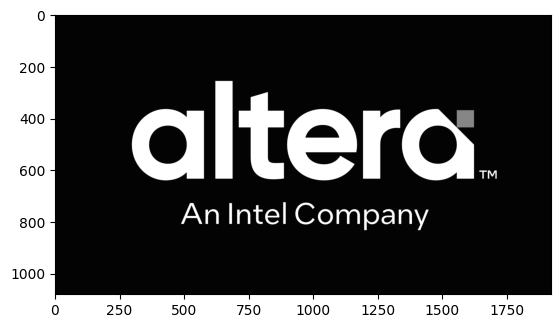

In [24]:
import matplotlib.pyplot as plt

# reading the sample image from a file
image = cv2.imread("../data/altera_logo.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

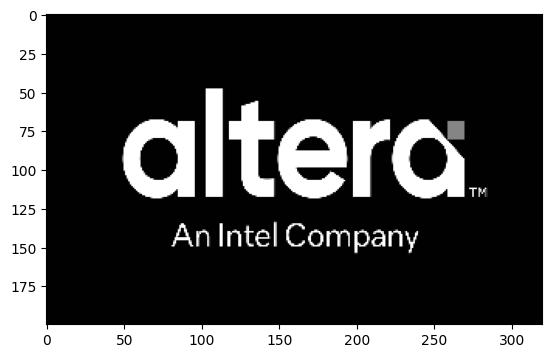

In [25]:
# Resize the image
resized_image = cv2.resize(image, (width, height))
plt.imshow(resized_image,cmap='gray')
plt.show()

In [26]:
def write_image(image):
    length = image.size
    for i in range(0x0,length,4):    
        printProgressBar(i,length)
        row = int(i/width)
        col = i%width
        pixel_data = (image[row][col]<<24|image[row][col+1]<<16|image[row][col+2]<<8|image[row][col+3]).astype(np.uint32)
        cmd = "write_32 0x{0:0x} 0x{1:08x}".format(i+read_buffer+0x4,pixel_data)
        cl.send_command(cmd)


In [27]:
def read_image(image):
    length = image.size
    for i in range(0x0,length,4):
        printProgressBar(i,length)
        row = int(i/width)
        col = i%width
        cmd = "read_32 0x{0:0x} 1".format(i+write_buffer+0x14)
        retval = cl.send_command(cmd)
        retint = int(retval[2:10],16)
        image[row][col+0] = retint>>24 & 0xff
        image[row][col+1] = retint>>16 & 0xff
        image[row][col+2] = retint>>8 & 0xff
        image[row][col+3] = retint & 0xff

In [28]:
write_image(resized_image)

In [29]:
blank_image = np.zeros((height, width, 1), dtype=np.uint8)
read_image(blank_image)

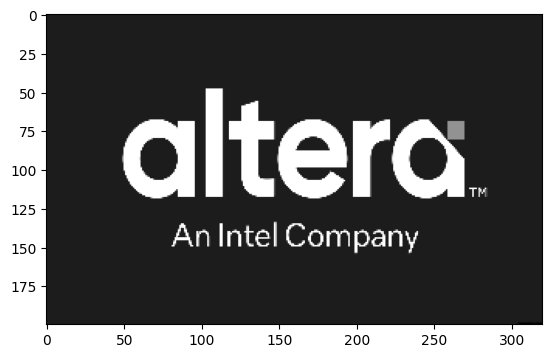

In [30]:
plt.imshow(blank_image,cmap='gray')
plt.show()

In [31]:
test_k = np.array([[ 0.5, 0, -0.5],
                    [1.0, 0, -1.0],
                    [0.5, 0, -0.5]])
update_kernel(test_k)

0

In [32]:
blank_image = np.zeros((height, width, 1), dtype=np.uint8)
read_image(blank_image)

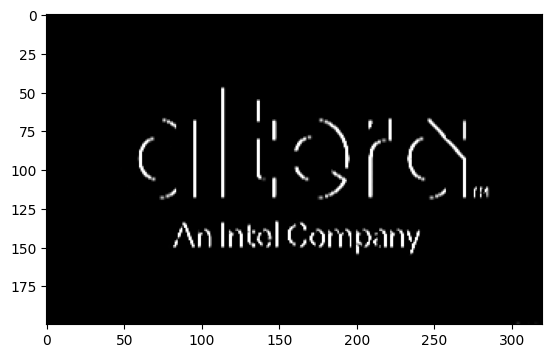

In [33]:
plt.imshow(blank_image,cmap='gray')
plt.show()

In [34]:
test_k = np.array([[ -0.125, -0.125, -0.125],
                    [-0.125,  1.000, -0.125],
                    [-0.125, -0.125, -0.125]])
update_kernel(test_k)

0

In [35]:
blank_image = np.zeros((height, width, 1), dtype=np.uint8)
read_image(blank_image)

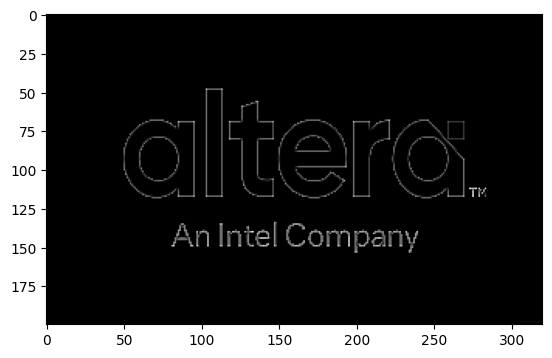

In [36]:
plt.imshow(blank_image,cmap='gray')
plt.show()

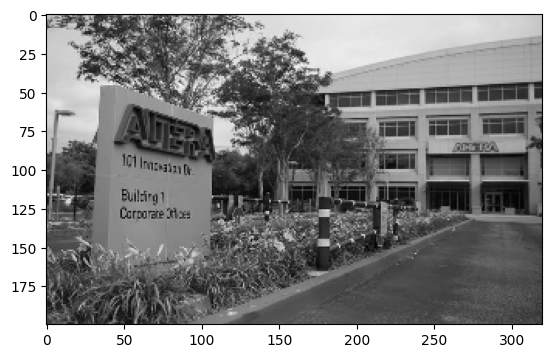

In [37]:
# reading the sample image from a file
image = cv2.imread("../data/altera_hq.jpg", cv2.IMREAD_GRAYSCALE)
# Resize the image
resized_image = cv2.resize(image, (width, height))
plt.imshow(resized_image,cmap='gray')
plt.show()

In [38]:
write_image(resized_image)

In [39]:
blank_image = np.zeros((height, width, 1), dtype=np.uint8)
read_image(blank_image)

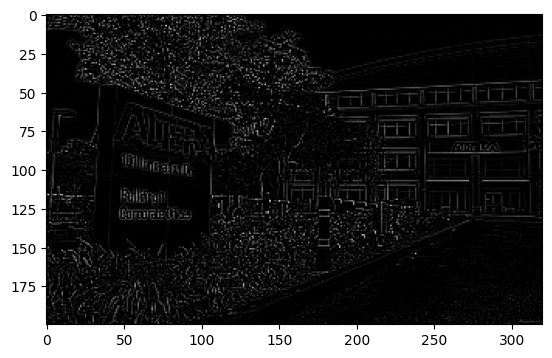

In [40]:
plt.imshow(blank_image,cmap='gray')
plt.show()

## Close Telnet

In [41]:
cl.close()